In [58]:
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import cost_function
from database import CityLearnDatabase, SQLiteDatabase

In [6]:
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0

# Reward Function Design
***
$E$ is an array of the district buildings' electricity demand, $n$ is the number of buildings in the district and $t$ is the current timestep.

1. __Default__
    $$
    r(t)^\textrm{def} = E(t)
    $$

2. __MARLISA__
    $$
    r(t)^\textrm{marl} = \textrm{sign}\left(r(t)^\textrm{def}\right) \times 0.01 \times \left|{r(t)^\textrm{def}}\right|^2 \times \textrm{max}\left(0, -\sum_{i=1}^{n-1}{r(t)^\textrm{def}_i}\right)
    $$

3. __SAC__
    $$
    r(t)^\textrm{sac} = \left[\textrm{min}\left(0,{r(t)_0^\textrm{def}}^3\right), \dots, \textrm{min}\left(0,{r(t)_{n-1}^\textrm{def}}^3\right)\right]
    $$

4. __Ramping Square__
    $$
    r(t)^\textrm{ramp} = \left[-\left(\left(\sum_{i=0}^{n-1}{r(t)^\textrm{def}_i} - \sum_{i=0}^{n-1}{r(t-1)^\textrm{def}_i}\right)^2\right)_0, \dots, -\left(\left(\sum_{i=0}^{n-1}{r(t)^\textrm{def}_i} - \sum_{i=0}^{n-1}{r(t-1)^\textrm{def}_i}\right)^2\right)_{n-1}\right] \div n
    $$

5. __Exponential__
    $$
    r(t)^\textrm{exp} = \left[\left(-e^{0.0002 \times \sum_{i=0}^{n-1}{-r(t)^\textrm{def}_i}}\right)_0, \dots, \left(-e^{0.0002 \times \sum_{i=0}^{n-1}{-r(t)^\textrm{def}_i}}\right)_{n-1}\right] \div n
    $$

    Where 0.0002 is a scaling factor to avoid high exponents defined as $\frac{\lambda}{50}$. We use $\lambda = 0.01$.

6. __Mixed__
    $$
    r(t)^\textrm{mix} = r(t)^\textrm{ramp} + r(t)^\textrm{exp}
    $$

# Simulation Analysis
***

### C8 
- training off-line from the fixed logs of an external behavior policy.The benchmark here is to learn a control law  from data generated by a sub-optimal reference controller, .e.g., a rule based controller, which is often available, essentially a system log. In addition to the control environment, datasets of various size, e.g.,two weeks, one months, 6 months should be provided that are generated with a known reference rule based controller. Then, the controllers can be evaluated on the ability to improve these baselines.

In [2]:
c8_simulation_output_directory = 'simulation_output_c8'
c8_database_filepath = os.path.join(c8_simulation_output_directory,'simulation_v1.db')
source_filepaths = [os.path.join(c8_simulation_output_directory,f'simulation_{i}.db') for i in range(1,7)]
CityLearnDatabase.concatenate(c8_database_filepath,source_filepaths)
database = SQLiteDatabase(c8_database_filepath)

Database: 6/6, Table: 22/22

In [3]:
# offline training periods
metadata = database.query_table("""
SELECT
    s.id AS simulation_id,
    e.id AS environment_id,
    a.name AS agent_name,
    AVG(a.exploration_period) AS exploration_period
FROM agent a
LEFT JOIN building b ON b.agent_id = a.id
LEFT JOIN environment e ON e.id = b.environment_id
LEFT JOIN simulation s ON s.id = e.simulation_id
GROUP BY
    s.id,
    e.id,
    a.name
""")
print('Simulation metadata')
display(metadata)
exploration_periods = database.query_table("SELECT DISTINCT exploration_period FROM agent")['exploration_period'].tolist()
agent_names = database.query_table("SELECT DISTINCT name FROM agent")['name'].tolist()

Simulation metadata


,simulation_id,environment_id,agent_name,exploration_period
0,1,1,marlisa,8760.0
1,2,2,marlisa,4344.0
2,3,3,marlisa,744.0
3,4,4,rbc,8760.0
4,5,5,rbc,4344.0
5,6,6,rbc,744.0


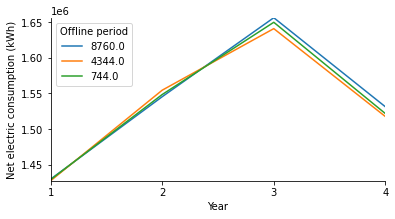

In [25]:
# environment level net electricity consumption
plot_metadata = metadata[metadata['agent_name']=='marlisa']
fig, ax = plt.subplots(1,1,figsize=(6,3))

for _, environment_id, _, exploration_period in plot_metadata.to_records(index=False):
    query = f"""
    SELECT
        CAST (t.timestep / 8760 AS INTEGER) + 1 AS year,
        SUM(e.net_electric_consumption) AS value
    FROM environment_timeseries e
    LEFT JOIN timestep t ON t.id = e.timestep_id
    WHERE e.environment_id = {environment_id}
    GROUP BY
        CAST (t.timestep / 8760 AS INTEGER) + 1
    """
    plot_data = database.query_table(query)
    x = plot_data['year']
    y = plot_data['value']
    ax.plot(x,y,label=exploration_period)
    ax.set_xticks(range(int(min(x)),int(max(x)+1)))
    ax.set_xlabel('Year')
    ax.set_ylabel('Net electric consumption (kWh)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

ax.legend(title='Offline period')
ax.margins(0)
plt.show()

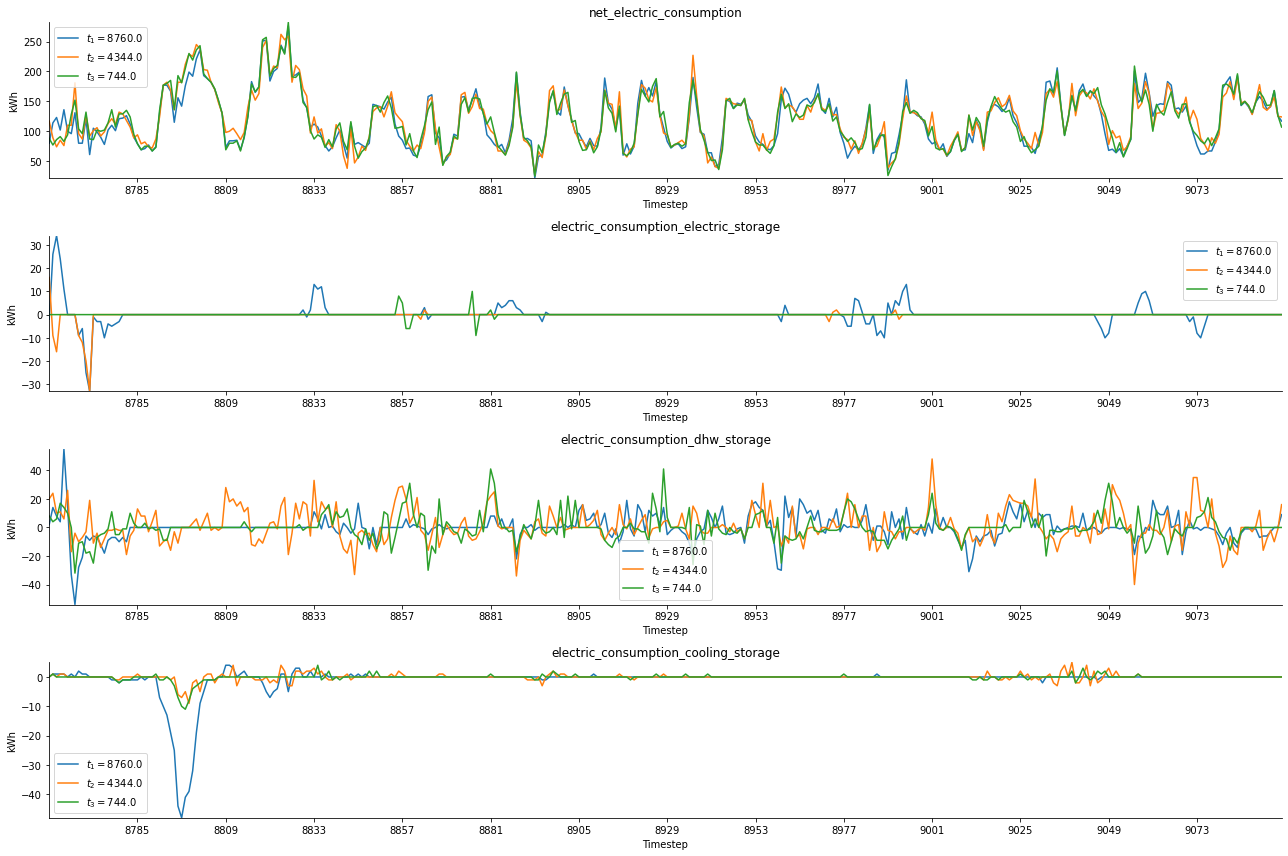

In [56]:
# environment cooling storage, dhw storage and electrical storage electrical charge and discharge power timeseries
columns = ['net_electric_consumption','electric_consumption_electric_storage','electric_consumption_dhw_storage','electric_consumption_cooling_storage']
fig, axs = plt.subplots(len(columns),1,figsize=(18,3*len(columns)))
plot_week_count = 2
daily_timesteps = 24
weekly_timesteps = 24*7
start_timestep = 8760
end_timestep = start_timestep + weekly_timesteps*plot_week_count
plot_period = (start_timestep,end_timestep)
exploration_timesteps_to_show = 0
plot_metadata = metadata[metadata['agent_name']=='marlisa']


for ax, column in zip(fig.axes, columns):
    for _, environment_id, _, exploration_period in plot_metadata.to_records(index=False):
        query = f"""
        SELECT
            t.timestep,
            e.{column} AS value
        FROM environment_timeseries e
        LEFT JOIN timestep t ON t.id = e.timestep_id
        WHERE e.environment_id = {environment_id}
        """
        plot_data = database.query_table(query).iloc[plot_period[0]:plot_period[1]+exploration_timesteps_to_show]
        x = plot_data['timestep']
        y = plot_data['value']
        ax.plot(x,y,label=rf'$t_{environment_id}={exploration_period}$')
    
    ax.xaxis.set_major_locator(ticker.IndexLocator(base=24,offset=24))
    ax.set_title(column)
    ax.legend()
    ax.set_xlabel('Timestep')
    ax.set_ylabel('kWh')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.show()


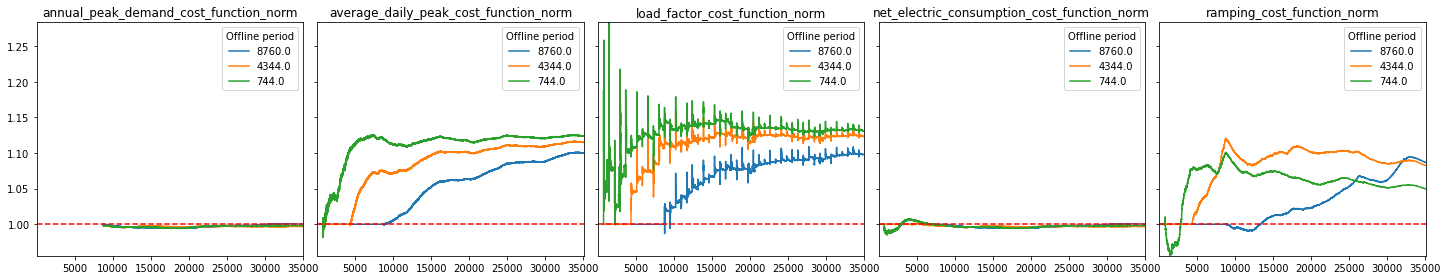

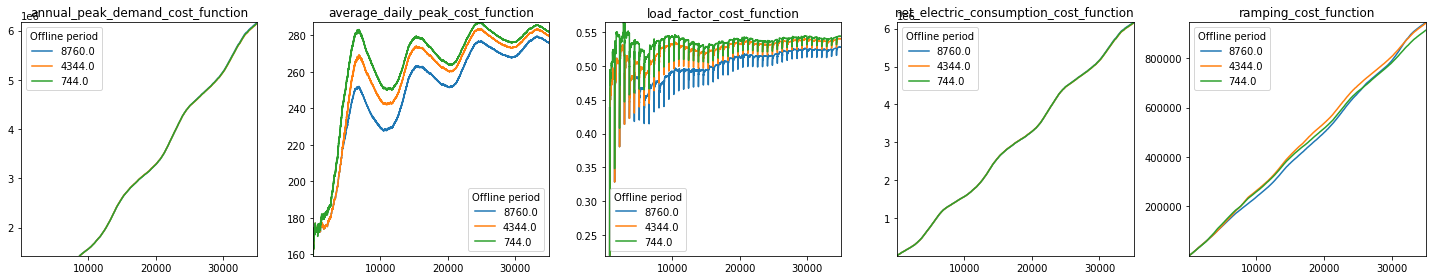

In [81]:
# # cost functions
# rbc_environment_id = 4
# plot_metadata = metadata[(metadata['agent_name']=='marlisa') | (metadata['environment_id']==rbc_environment_id)]
# plot_data_list = []

# for i, (_, environment_id, _, exploration_period) in enumerate(plot_metadata.to_records(index=False)):
#     print(f'\r{i+1}/{plot_metadata.shape[0]}',end='')
#     query = query = f"""
#     SELECT
#         t.timestep,
#         e.net_electric_consumption
#     FROM environment_timeseries e
#     LEFT JOIN timestep t ON t.id = e.timestep_id
#     WHERE e.environment_id = {environment_id}
#     """
#     plot_data = database.query_table(query)
    
#     # cost functions
#     plot_data['ramping_cost_function'] = plot_data['net_electric_consumption'].rolling(
#         window=plot_data.shape[0],min_periods=2
#     ).apply(lambda x: cost_function.ramping(x),raw=True)
#     plot_data['load_factor_cost_function'] = plot_data['net_electric_consumption'].rolling(
#         window=plot_data.shape[0],min_periods=730
#     ).apply(lambda x: cost_function.load_factor(x),raw=True)
#     plot_data['average_daily_peak_cost_function'] = plot_data['net_electric_consumption'].rolling(
#         window=plot_data.shape[0],min_periods=24
#     ).apply(lambda x: cost_function.average_daily_peak(x),raw=True)
#     plot_data['annual_peak_demand_cost_function'] = plot_data['net_electric_consumption'].rolling(
#         window=plot_data.shape[0],min_periods=8760
#     ).apply(lambda x: cost_function.net_electric_consumption(x),raw=True)
#     plot_data['net_electric_consumption_cost_function'] = plot_data['net_electric_consumption'].rolling(
#         window=plot_data.shape[0],min_periods=1
#     ).apply(lambda x: cost_function.net_electric_consumption(x),raw=True)
#     plot_data['environment_id'] = environment_id
#     plot_data['exploration_period'] = exploration_period
#     plot_data_list.append(plot_data)

# calculate normalized cost
plot_data = pd.concat(plot_data_list,ignore_index=True)
plot_data = plot_data.drop(columns=['net_electric_consumption'])
cost_function_columns = [c for c in plot_data.columns if c.endswith('cost_function')]
id_vars = [c for c in plot_data.columns if c not in cost_function_columns]
plot_data = plot_data.melt(id_vars=id_vars,value_vars=cost_function_columns)
plot_data['variable'] += '_norm'
rbc_data = plot_data[plot_data['environment_id']==rbc_environment_id].copy()
rbc_data = rbc_data.rename(columns={'value':'baseline_value'})
rbc_data = rbc_data[['timestep','variable','baseline_value']].copy()
plot_data = pd.merge(plot_data,rbc_data,on=['timestep','variable'],how='left')
plot_data['norm_value'] = plot_data['value']/plot_data['baseline_value']
plot_data = plot_data[plot_data['environment_id']!=rbc_environment_id].copy()

# plot normalized cost functions
row_count = 1
column_count = len(cost_function_columns)
figsize = (4*column_count,4*row_count)
fig, axs = plt.subplots(row_count,column_count,figsize=figsize,sharey=True,sharex=True)

for ax, (variable, var_group) in zip(fig.axes, plot_data.groupby(['variable'])):
    for (environment_id, exploration_period), env_group in var_group.groupby(['environment_id','exploration_period']):
        x, y = env_group['timestep'], env_group['norm_value']
        ax.plot(x,y,label=exploration_period)

    ax.set_title(f'{variable}')
    ax.axhline(1,color='red',linestyle='--')
    ax.legend(title='Offline period')

plt.tight_layout()
plt.show()

# plot not normalized cost functions
row_count = 1
column_count = len(cost_function_columns)
figsize = (4*column_count,4*row_count)
fig, axs = plt.subplots(row_count,column_count,figsize=figsize,sharex=True)

for ax, (variable, var_group) in zip(fig.axes, plot_data.groupby(['variable'])):
    for (environment_id, exploration_period), env_group in var_group.groupby(['environment_id','exploration_period']):
        x, y = env_group['timestep'], env_group['value']
        ax.plot(x,y,label=exploration_period)

    ax.set_title(f'{variable.replace("_norm","")}')
    # ax.axhline(1,color='red',linestyle='--')
    ax.legend(title='Offline period')

plt.tight_layout()
plt.show()

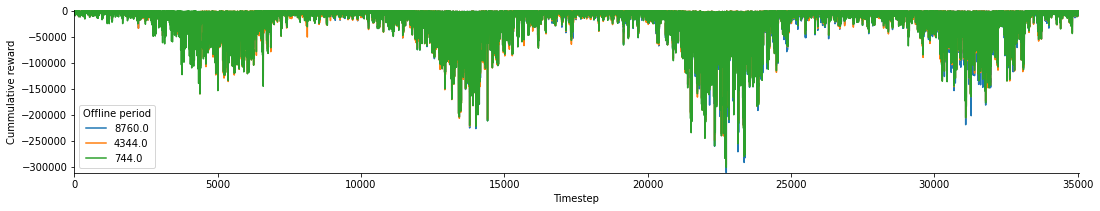

In [31]:
# cummulatiove reward timeseries
plot_metadata = metadata[metadata['agent_name']=='marlisa']
fig, ax = plt.subplots(1,1,figsize=(18,3))

for _, environment_id, _, exploration_period in plot_metadata.to_records(index=False):
    query = f"""
    SELECT
        t.timestep,
        SUM(r.value) AS value
    FROM reward_timeseries r
    LEFT JOIN timestep t ON t.id = r.timestep_id
    WHERE t.environment_id = {environment_id}
    GROUP BY
        t.timestep
    """
    plot_data = database.query_table(query)
    x = plot_data['timestep']
    y = plot_data['value']
    ax.plot(x,y,label=exploration_period)
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Cummulative reward')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

ax.legend(title='Offline period')
ax.margins(0)
plt.show()
    